# Congestion Simulation

We simulate the ethereum market in both the status quo and under EIP-1559. Both simulations draw from the same distribution of "values", which quantify the amount that users inherently value their transaction. Both simulations also draw from the same "gas used" distributions.

We first import the necessary libraries:

In [19]:
import numpy as np
import pandas as pd
import math
from collections import deque
import matplotlib.pyplot as plt
import cProfile
import random

Throughout the simulation, we keep track of blocks filled and oracle prediction values generated. 

In [20]:
sq_current_oracle = 0
eip_current_oracle = 0 

sq_blocks = []
eip_blocks = []

sq_block_mins =  deque([])
eip_block_mins = deque([])

At every iteration of the simulation, a block is filled with the most lucrative transactions in the mempool, and the mempool is filled again with 2000 transactions. In the function defined below, 2000 samples are taken from the "values" and "gas used" distributions, price mapped to Status Quo and EIP-1559 simulations, and added to the existing mempool. 

In [21]:
def create_mempool(txn_number, sq_df, eip_df, basefee, t=0):
  
    global sq_current_oracle, eip_current_oracle

    values = np.random.gamma(20.72054, 1/17.49951, txn_number)
    gas_limit = (np.random.pareto(1.42150, txn_number)+1)*21000  # pareto distribution with alpha 1.42150, beta 21000
    
    sq_gas_prices = [sq_current_oracle * v for v in values] 
    eip_gas_prices = [min(basefee + (eip_current_oracle * v), sq_current_oracle * v) for v in values]   
    
#     print(values)
#     print(gas_limit)
    
    # store each updated mempool as a DataFrame

    sq_df = sq_df.append(pd.DataFrame({
        'gas price': sq_gas_prices,
        'gas limit': gas_limit,
        'time' : t,
        'amount paid': [x * y for x,y in zip(sq_gas_prices,gas_limit)]
        }), ignore_index=True)
    

    eip_df = eip_df.append(pd.DataFrame({
        'gas price': eip_gas_prices,
        'gas limit': gas_limit,
        'time': t,
        'amount paid' : [x * y for x,y in zip(eip_gas_prices,gas_limit)]
        }), ignore_index=True)
    
    # sort transactions in each mempool by gas price
    
    sq_df = sq_df.sort_values(by=['gas price'], ascending=False).reset_index(drop=True)
    eip_df = eip_df.sort_values(by=['gas price'], ascending=False).reset_index(drop=True)
    
    return sq_df, eip_df

We define some helper functions. First, a function to calculate a new basefee. Second, a function to update the oracle values for each transaction. We create a sorted list of the smallest (lowest gas-price) transactions from the previous hundred blocks. The oracle value is defined as the 60th item in that list. Finally, we need functions to fill blocks for both simulations. Because the protocols have different rules on this, we pass a basefee of 0 in the Status Quo simulation and pass in the actual basefee in the EIP-1559 simulation. 

In [22]:
def get_basefee(b, g): 
    
    return b*(1+(1/8)*((g-15000000)/15000000))

def get_oracle():
    
    global sq_current_oracle, sq_block_mins, sq_blocks, eip_block_mins, eip_current_oracle, eip_blocks
    
    update_oracle(sq_current_oracle, sq_block_mins, sq_blocks)
    update_oracle(eip_current_oracle, eip_block_mins, eip_blocks)

def update_oracle(current_oracle, block_minimums, blocks):
    recent_gp = blocks[-1][-1][1]
    block_minimums.popleft()
    block_minimums.append(recent_gp)

    sorted_block_minimums = sorted(block_minimums)
  
    current_oracle = sorted_block_minimums[59]

def fill_block(mempool, basefee):
    block = []
    block_size = 0
    block_limit = 30000000 if basefee > 0 else 15000000
    
    for i in range(len(mempool)):
        txn = mempool.iloc[i, :].tolist()
        if block_size + txn[1] > block_limit or txn[0] < basefee:
            break
        else:
            block.append(txn)
            block_size += txn[1]
    
    #remove verified txns from mempool
    mempool = mempool.iloc[i+1:,:]    
    return block, mempool, block_size

The simulation is ran in the following function, storing data on each iteration. 

In [23]:
def simulate(n):
    
    #initialize empty dataframes
    df1 = pd.DataFrame() 
    df2 = pd.DataFrame() 
    
    sq_block_data = pd.DataFrame()
    eip_block_data = pd.DataFrame()
   
    sq_mempool_data = pd.DataFrame()
    eip_mempool_data = pd.DataFrame()
    
    basefee = 60
    basefees = [basefee]
    sq_mempools = []
    eip_mempools = []
    eip_mempools_bf = []
    
    global sq_block_mins, eip_block_mins, sq_blocks, sq_current_oracle, eip_current_oracle, eip_blocks
    
    #read in data to initialize oracle
    data = pd.read_csv('block_data.csv')
    minGasdf = data[['gasLimit','minGasPrice']].values 
    for d in minGasdf:
        if len(eip_block_mins) == 100:
            break
        if d[1] == 'None':
            continue
        sq_block_mins.append(int(d[1]) / 10**9)
        eip_block_mins.append(int(d[1]) / 10**9)
    
    sorted_sq_block_mins = sorted(sq_block_mins)
    sorted_eip_block_mins = sorted([x - basefee for x in eip_block_mins])
    
    #set initial oracles
    sq_current_oracle = sorted_sq_block_mins[59]
    eip_current_oracle = sorted_eip_block_mins[59]
    
    #initialize mempools with 2000 txns
    sq_mempool, eip_mempool = create_mempool(700, df1, df2, basefee)
    
    #iterate over n blocks
    for i in range(n):
        
        #fill blocks from mempools
        new_sq_block, new_sq_mempool, sq_blocksize = fill_block(sq_mempool, 0)
        new_eip_block, new_eip_mempool, eip_blocksize = fill_block(sq_mempool, basefee)
        
        sq_blocks += [new_sq_block]
        eip_blocks += [new_eip_block]
        
        get_oracle()
        
        #update mempools
        sq_mempool = new_sq_mempool
        eip_mempool = new_eip_mempool
        
        basefee = get_basefee(basefee, eip_blocksize)
        basefees += [basefee]
        
        #add 200 new txns before next iteration
        sq_mempool, eip_mempool = create_mempool(random.randint(1, 400), sq_mempool, eip_mempool, basefee, i+1) #randomly select from 100 to 600
        
        sq_mempools += [sq_mempool]
        eip_mempools += [eip_mempool]
        eip_mempools_bf += [eip_mempool[eip_mempool['gas price'] >= basefee]]
        
        print("progress: ", i+1, end = '\r')
    return basefees, eip_blocks, sq_blocks, eip_mempools, sq_mempools, eip_mempools_bf 

We run the simulation and save the summary data.

In [24]:
s = simulate(200)
basefees_data = s[0]
eip_blocks_data = s[1]
sq_blocks_data = s[2]
eip_mempools_data = s[3]
sq_mempools_data = s[4]
eip_mempools_bf_data = s[5]

# cProfile.run("simulate(100)")

# Basefee over time:

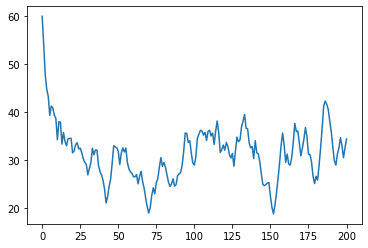

In [25]:
plt.plot(basefees_data)

# Mempool Sizes Over Time

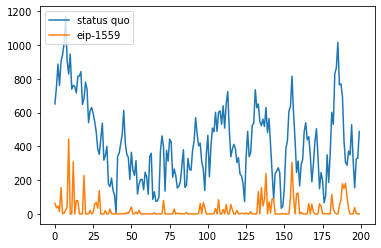

In [26]:
sq_mempool_sizes = [len(x) for x in sq_mempools_data]
eip_mempool_sizes = [len(x) for x in eip_mempools_bf_data]

plt.plot(sq_mempool_sizes, label="status quo")
plt.plot(eip_mempool_sizes, label="eip-1559")
plt.legend(loc="upper left")

# Average Weight of Mempools

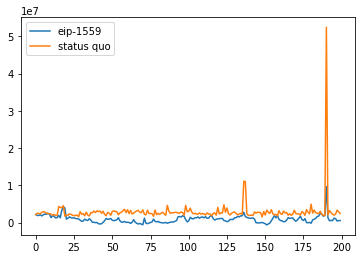

In [27]:
eip_mempool_avgs = [sum(i["amount paid"]) / len(i) for i in eip_mempools_data]
sq_mempool_avgs = [sum(i["amount paid"]) / len(i) for i in sq_mempools_data]
plt.plot(eip_mempool_avgs, label="eip-1559")
plt.plot(sq_mempool_avgs, label="status quo")
plt.legend(loc="upper left")

# Average Gas Price by Block